In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
def transform_map(m):
    m = m.squeeze()
    idx0 = np.arange(m.shape[0])[m.sum(axis=1) != 0][[0, -1]] + [-5, 5]
    idx1 = np.arange(m.shape[1])[m.sum(axis=0) != 0][[0, -1]] + [-5, 5]
    len0 = idx0[1] - idx0[0]
    len1 = idx1[1] - idx1[0]
    idx0[1] += len0 % 2
    idx1[1] += len1 % 2
    len0 = idx0[1] - idx0[0]
    len1 = idx1[1] - idx1[0]
    if len0 > len1:
        diff = (len0 - len1) // 2
        idx1 += [-diff, diff]
    elif len1 > len0:
        diff = (len1 - len0) // 2
        idx0 += [-diff, diff]

    mm = m[idx0[0]:idx0[1], idx1[0]:idx1[1]]
    return transforms.Resize(size=(200, 200), antialias=True)(mm[None, :, :])

In [11]:
log_dir = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/log/"

maps = np.concatenate([np.load(log_dir + f + "/maps.npy") for f in os.listdir(log_dir) if f.find("2023") == 0], axis=0)

maps[maps == 100] = 1
maps += 1
maps = torch.from_numpy(maps).to(torch.float32)
maps /= maps.max()

maps = torch.stack([transform_map(m).to(device) for m in maps])


In [12]:
maps.shape

torch.Size([11849, 1, 200, 200])

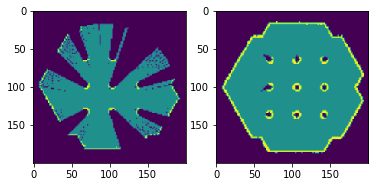

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(maps[0].cpu().numpy().squeeze())

plt.subplot(1, 2, 2)
plt.imshow(maps[-1].cpu().numpy().squeeze())

plt.show()

In [18]:
train_data, test_data = train_test_split(maps, test_size=0.2, shuffle=True)

In [19]:
class Encoder384(nn.Module):
    def __init__(self) -> None:
        super(Encoder384, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(4, 4, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(4, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


encoder = Encoder384()
m = torch.rand(10, 1, 384, 384)
encoder(m).shape

torch.Size([10, 256])

In [20]:
class Decoder384(nn.Module):
    def __init__(self) -> None:
        super(Decoder384, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=3),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(4, 4, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3),
            nn.ReLU(),
        )

    def forward(self, x):
        x = x.reshape(-1, 64, 2, 2)
        x = self.decoder(x)
        return x


decoder = Decoder384()
m = torch.rand(10, 256)
decoder(m).shape

torch.Size([10, 1, 384, 384])

In [21]:
class Autoencoder384(nn.Module):
    def __init__(self) -> None:
        super(Autoencoder384, self).__init__()
        self.encoder = Encoder384()
        self.decoder = Decoder384()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


autoencoder = Autoencoder384()

In [22]:
class Encoder200(nn.Module):
    def __init__(self) -> None:
        super(Encoder200, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(4, 4, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(4, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


encoder = Encoder200()
m = torch.rand(10, 1, 200, 200)
encoder(m).shape

torch.Size([10, 256])

In [23]:
class Decoder200(nn.Module):
    def __init__(self) -> None:
        super(Decoder200, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=3),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(4, 4, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.reshape(-1, 64, 2, 2)
        x = self.decoder(x)
        return x


decoder = Decoder200()
m = torch.rand(10, 256)
decoder(m).shape

torch.Size([10, 1, 200, 200])

In [24]:
class Autoencoder200(nn.Module):
    def __init__(self) -> None:
        super(Autoencoder200, self).__init__()
        self.encoder = Encoder200()
        self.decoder = Decoder200()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


autoencoder = Autoencoder200()

In [25]:
cirterion = nn.L1Loss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [26]:
autoencoder = autoencoder.to(device)

In [27]:
train_dataset = data_utils.TensorDataset(train_data)
test_dataset = data_utils.TensorDataset(test_data)

train_data_loader = data_utils.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_data_loader = data_utils.DataLoader(test_dataset, batch_size=128, shuffle=True)

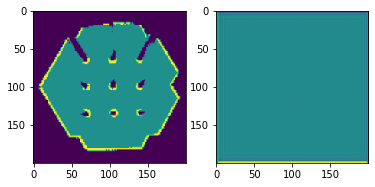

In [28]:
def plot_result(index = -1):
    if index == -1:
      index = np.random.randint(len(test_data))

    plt.subplot(1, 2, 1)
    plt.imshow(test_data[index].cpu().squeeze())

    with torch.no_grad():
        result = autoencoder(test_data[index])
    plt.subplot(1, 2, 2)
    plt.imshow(result[0].cpu().squeeze())
    plt.show()

plot_result()

Epoch [1/30], Step [5/75], Loss: 0.261064
Epoch [1/30], Step [10/75], Loss: 0.259720
Epoch [1/30], Step [15/75], Loss: 0.254985
Epoch [1/30], Step [20/75], Loss: 0.253451
Epoch [1/30], Step [25/75], Loss: 0.252630
Epoch [1/30], Step [30/75], Loss: 0.244844
Epoch [1/30], Step [35/75], Loss: 0.236912
Epoch [1/30], Step [40/75], Loss: 0.234776
Epoch [1/30], Step [45/75], Loss: 0.229490
Epoch [1/30], Step [50/75], Loss: 0.219500
Epoch [1/30], Step [55/75], Loss: 0.181389
Epoch [1/30], Step [60/75], Loss: 0.135115
Epoch [1/30], Step [65/75], Loss: 0.110394
Epoch [1/30], Step [70/75], Loss: 0.101118
Epoch [1/30], Step [75/75], Loss: 0.110490
Epoch [1/30], Average Train Loss: 0.209611, Average Test Loss: 0.090362


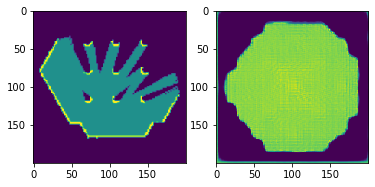

Epoch [2/30], Step [5/75], Loss: 0.090840
Epoch [2/30], Step [10/75], Loss: 0.086814
Epoch [2/30], Step [15/75], Loss: 0.083199
Epoch [2/30], Step [20/75], Loss: 0.080203
Epoch [2/30], Step [25/75], Loss: 0.081708
Epoch [2/30], Step [30/75], Loss: 0.078914
Epoch [2/30], Step [35/75], Loss: 0.081398
Epoch [2/30], Step [40/75], Loss: 0.075907
Epoch [2/30], Step [45/75], Loss: 0.071915
Epoch [2/30], Step [50/75], Loss: 0.081058
Epoch [2/30], Step [55/75], Loss: 0.071150
Epoch [2/30], Step [60/75], Loss: 0.073541
Epoch [2/30], Step [65/75], Loss: 0.075894
Epoch [2/30], Step [70/75], Loss: 0.079443
Epoch [2/30], Step [75/75], Loss: 0.080438
Epoch [2/30], Average Train Loss: 0.078881, Average Test Loss: 0.074634


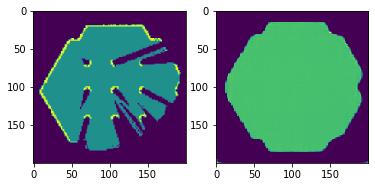

Epoch [3/30], Step [5/75], Loss: 0.076598
Epoch [3/30], Step [10/75], Loss: 0.075178
Epoch [3/30], Step [15/75], Loss: 0.073477
Epoch [3/30], Step [20/75], Loss: 0.078066
Epoch [3/30], Step [25/75], Loss: 0.071950
Epoch [3/30], Step [30/75], Loss: 0.076376
Epoch [3/30], Step [35/75], Loss: 0.077852
Epoch [3/30], Step [40/75], Loss: 0.072312
Epoch [3/30], Step [45/75], Loss: 0.078083
Epoch [3/30], Step [50/75], Loss: 0.078030
Epoch [3/30], Step [55/75], Loss: 0.083242
Epoch [3/30], Step [60/75], Loss: 0.080905
Epoch [3/30], Step [65/75], Loss: 0.076708
Epoch [3/30], Step [70/75], Loss: 0.077696
Epoch [3/30], Step [75/75], Loss: 0.074721
Epoch [3/30], Average Train Loss: 0.076001, Average Test Loss: 0.074635


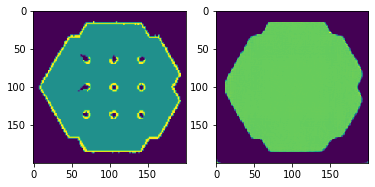

Epoch [4/30], Step [5/75], Loss: 0.074473
Epoch [4/30], Step [10/75], Loss: 0.075912
Epoch [4/30], Step [15/75], Loss: 0.070475
Epoch [4/30], Step [20/75], Loss: 0.070253
Epoch [4/30], Step [25/75], Loss: 0.071447
Epoch [4/30], Step [30/75], Loss: 0.080149
Epoch [4/30], Step [35/75], Loss: 0.078079
Epoch [4/30], Step [40/75], Loss: 0.073787
Epoch [4/30], Step [45/75], Loss: 0.074582
Epoch [4/30], Step [50/75], Loss: 0.076550
Epoch [4/30], Step [55/75], Loss: 0.069656
Epoch [4/30], Step [60/75], Loss: 0.073839
Epoch [4/30], Step [65/75], Loss: 0.082529
Epoch [4/30], Step [70/75], Loss: 0.071793
Epoch [4/30], Step [75/75], Loss: 0.071865
Epoch [4/30], Average Train Loss: 0.074793, Average Test Loss: 0.074301


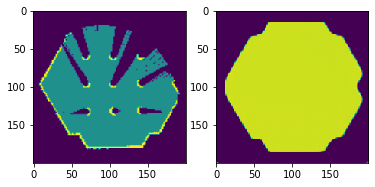

Epoch [5/30], Step [5/75], Loss: 0.069479
Epoch [5/30], Step [10/75], Loss: 0.079027
Epoch [5/30], Step [15/75], Loss: 0.076812
Epoch [5/30], Step [20/75], Loss: 0.074221
Epoch [5/30], Step [25/75], Loss: 0.075499
Epoch [5/30], Step [30/75], Loss: 0.078272
Epoch [5/30], Step [35/75], Loss: 0.073049
Epoch [5/30], Step [40/75], Loss: 0.074457
Epoch [5/30], Step [45/75], Loss: 0.076212
Epoch [5/30], Step [50/75], Loss: 0.076577
Epoch [5/30], Step [55/75], Loss: 0.075713
Epoch [5/30], Step [60/75], Loss: 0.076327
Epoch [5/30], Step [65/75], Loss: 0.074906
Epoch [5/30], Step [70/75], Loss: 0.071532
Epoch [5/30], Step [75/75], Loss: 0.074361
Epoch [5/30], Average Train Loss: 0.074310, Average Test Loss: 0.073924


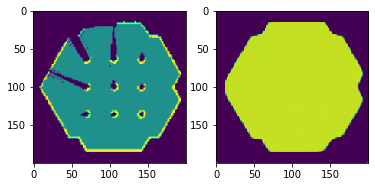

Epoch [6/30], Step [5/75], Loss: 0.070988
Epoch [6/30], Step [10/75], Loss: 0.072056
Epoch [6/30], Step [15/75], Loss: 0.084761
Epoch [6/30], Step [20/75], Loss: 0.077318
Epoch [6/30], Step [25/75], Loss: 0.072861
Epoch [6/30], Step [30/75], Loss: 0.072918
Epoch [6/30], Step [35/75], Loss: 0.071922
Epoch [6/30], Step [40/75], Loss: 0.077730
Epoch [6/30], Step [45/75], Loss: 0.073483
Epoch [6/30], Step [50/75], Loss: 0.073391
Epoch [6/30], Step [55/75], Loss: 0.072148
Epoch [6/30], Step [60/75], Loss: 0.076238
Epoch [6/30], Step [65/75], Loss: 0.071599
Epoch [6/30], Step [70/75], Loss: 0.074224
Epoch [6/30], Step [75/75], Loss: 0.086126
Epoch [6/30], Average Train Loss: 0.074128, Average Test Loss: 0.073558


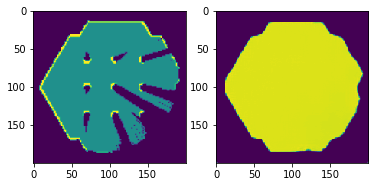

Epoch [7/30], Step [5/75], Loss: 0.077864
Epoch [7/30], Step [10/75], Loss: 0.073412
Epoch [7/30], Step [15/75], Loss: 0.074310
Epoch [7/30], Step [20/75], Loss: 0.072503
Epoch [7/30], Step [25/75], Loss: 0.063565
Epoch [7/30], Step [30/75], Loss: 0.075732
Epoch [7/30], Step [35/75], Loss: 0.069470
Epoch [7/30], Step [40/75], Loss: 0.071120
Epoch [7/30], Step [45/75], Loss: 0.074032
Epoch [7/30], Step [50/75], Loss: 0.078432
Epoch [7/30], Step [55/75], Loss: 0.071395
Epoch [7/30], Step [60/75], Loss: 0.072942
Epoch [7/30], Step [65/75], Loss: 0.065364
Epoch [7/30], Step [70/75], Loss: 0.066668
Epoch [7/30], Step [75/75], Loss: 0.054014
Epoch [7/30], Average Train Loss: 0.071984, Average Test Loss: 0.067304


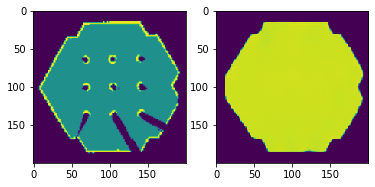

Epoch [8/30], Step [5/75], Loss: 0.065476
Epoch [8/30], Step [10/75], Loss: 0.068018
Epoch [8/30], Step [15/75], Loss: 0.063706
Epoch [8/30], Step [20/75], Loss: 0.061940
Epoch [8/30], Step [25/75], Loss: 0.061395
Epoch [8/30], Step [30/75], Loss: 0.058971
Epoch [8/30], Step [35/75], Loss: 0.058641
Epoch [8/30], Step [40/75], Loss: 0.056767
Epoch [8/30], Step [45/75], Loss: 0.057349
Epoch [8/30], Step [50/75], Loss: 0.057086
Epoch [8/30], Step [55/75], Loss: 0.057377
Epoch [8/30], Step [60/75], Loss: 0.056360
Epoch [8/30], Step [65/75], Loss: 0.056118
Epoch [8/30], Step [70/75], Loss: 0.053903
Epoch [8/30], Step [75/75], Loss: 0.048034
Epoch [8/30], Average Train Loss: 0.059111, Average Test Loss: 0.054650


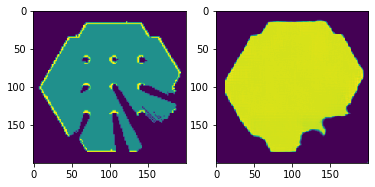

Epoch [9/30], Step [5/75], Loss: 0.055027
Epoch [9/30], Step [10/75], Loss: 0.053674
Epoch [9/30], Step [15/75], Loss: 0.051475
Epoch [9/30], Step [20/75], Loss: 0.053688
Epoch [9/30], Step [25/75], Loss: 0.052428
Epoch [9/30], Step [30/75], Loss: 0.056539
Epoch [9/30], Step [35/75], Loss: 0.053884
Epoch [9/30], Step [40/75], Loss: 0.053034
Epoch [9/30], Step [45/75], Loss: 0.053135
Epoch [9/30], Step [50/75], Loss: 0.053274
Epoch [9/30], Step [55/75], Loss: 0.053181
Epoch [9/30], Step [60/75], Loss: 0.054369
Epoch [9/30], Step [65/75], Loss: 0.052713
Epoch [9/30], Step [70/75], Loss: 0.050727
Epoch [9/30], Step [75/75], Loss: 0.051555
Epoch [9/30], Average Train Loss: 0.052962, Average Test Loss: 0.052346


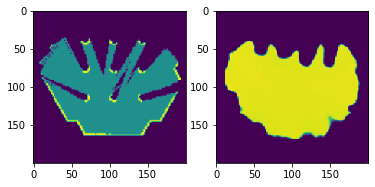

Epoch [10/30], Step [5/75], Loss: 0.052044
Epoch [10/30], Step [10/75], Loss: 0.052249
Epoch [10/30], Step [15/75], Loss: 0.052171
Epoch [10/30], Step [20/75], Loss: 0.050730
Epoch [10/30], Step [25/75], Loss: 0.051020
Epoch [10/30], Step [30/75], Loss: 0.051740
Epoch [10/30], Step [35/75], Loss: 0.053431
Epoch [10/30], Step [40/75], Loss: 0.050275
Epoch [10/30], Step [45/75], Loss: 0.050209
Epoch [10/30], Step [50/75], Loss: 0.051489
Epoch [10/30], Step [55/75], Loss: 0.050046
Epoch [10/30], Step [60/75], Loss: 0.049520
Epoch [10/30], Step [65/75], Loss: 0.049865
Epoch [10/30], Step [70/75], Loss: 0.048534
Epoch [10/30], Step [75/75], Loss: 0.050033
Epoch [10/30], Average Train Loss: 0.050519, Average Test Loss: 0.050564


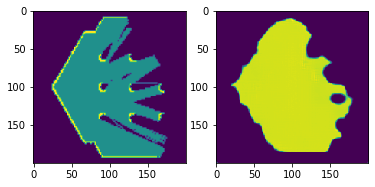

Epoch [11/30], Step [5/75], Loss: 0.049958
Epoch [11/30], Step [10/75], Loss: 0.047440
Epoch [11/30], Step [15/75], Loss: 0.051025
Epoch [11/30], Step [20/75], Loss: 0.049818
Epoch [11/30], Step [25/75], Loss: 0.051351
Epoch [11/30], Step [30/75], Loss: 0.047865
Epoch [11/30], Step [35/75], Loss: 0.048734
Epoch [11/30], Step [40/75], Loss: 0.046200
Epoch [11/30], Step [45/75], Loss: 0.047084
Epoch [11/30], Step [50/75], Loss: 0.050024
Epoch [11/30], Step [55/75], Loss: 0.049187
Epoch [11/30], Step [60/75], Loss: 0.049822
Epoch [11/30], Step [65/75], Loss: 0.047160
Epoch [11/30], Step [70/75], Loss: 0.047906
Epoch [11/30], Step [75/75], Loss: 0.056791
Epoch [11/30], Average Train Loss: 0.048661, Average Test Loss: 0.047997


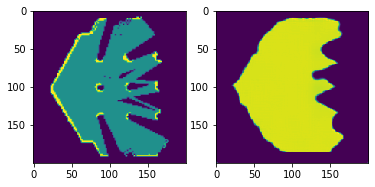

Epoch [12/30], Step [5/75], Loss: 0.046465
Epoch [12/30], Step [10/75], Loss: 0.046075
Epoch [12/30], Step [15/75], Loss: 0.045841
Epoch [12/30], Step [20/75], Loss: 0.046173
Epoch [12/30], Step [25/75], Loss: 0.046736
Epoch [12/30], Step [30/75], Loss: 0.045635
Epoch [12/30], Step [35/75], Loss: 0.045502
Epoch [12/30], Step [40/75], Loss: 0.046585
Epoch [12/30], Step [45/75], Loss: 0.044890
Epoch [12/30], Step [50/75], Loss: 0.046205
Epoch [12/30], Step [55/75], Loss: 0.045487
Epoch [12/30], Step [60/75], Loss: 0.045370
Epoch [12/30], Step [65/75], Loss: 0.045829
Epoch [12/30], Step [70/75], Loss: 0.045637
Epoch [12/30], Step [75/75], Loss: 0.049178
Epoch [12/30], Average Train Loss: 0.046070, Average Test Loss: 0.045400


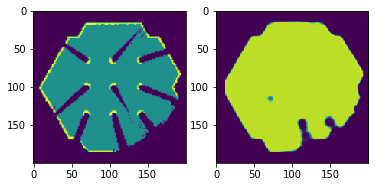

Epoch [13/30], Step [5/75], Loss: 0.045899
Epoch [13/30], Step [10/75], Loss: 0.044625
Epoch [13/30], Step [15/75], Loss: 0.047139
Epoch [13/30], Step [20/75], Loss: 0.044409
Epoch [13/30], Step [25/75], Loss: 0.044455
Epoch [13/30], Step [30/75], Loss: 0.045200
Epoch [13/30], Step [35/75], Loss: 0.044332
Epoch [13/30], Step [40/75], Loss: 0.043509
Epoch [13/30], Step [45/75], Loss: 0.043211
Epoch [13/30], Step [50/75], Loss: 0.044111
Epoch [13/30], Step [55/75], Loss: 0.044046
Epoch [13/30], Step [60/75], Loss: 0.045336
Epoch [13/30], Step [65/75], Loss: 0.045191
Epoch [13/30], Step [70/75], Loss: 0.044212
Epoch [13/30], Step [75/75], Loss: 0.040254
Epoch [13/30], Average Train Loss: 0.044211, Average Test Loss: 0.043573


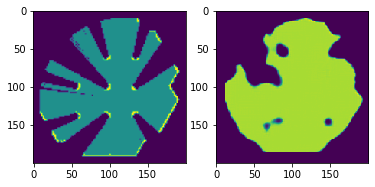

Epoch [14/30], Step [5/75], Loss: 0.043333
Epoch [14/30], Step [10/75], Loss: 0.045312
Epoch [14/30], Step [15/75], Loss: 0.042692
Epoch [14/30], Step [20/75], Loss: 0.043873
Epoch [14/30], Step [25/75], Loss: 0.042998
Epoch [14/30], Step [30/75], Loss: 0.043016
Epoch [14/30], Step [35/75], Loss: 0.040779
Epoch [14/30], Step [40/75], Loss: 0.042783
Epoch [14/30], Step [45/75], Loss: 0.044705
Epoch [14/30], Step [50/75], Loss: 0.041895
Epoch [14/30], Step [55/75], Loss: 0.044188
Epoch [14/30], Step [60/75], Loss: 0.045259
Epoch [14/30], Step [65/75], Loss: 0.041633
Epoch [14/30], Step [70/75], Loss: 0.041526
Epoch [14/30], Step [75/75], Loss: 0.040369
Epoch [14/30], Average Train Loss: 0.043008, Average Test Loss: 0.042497


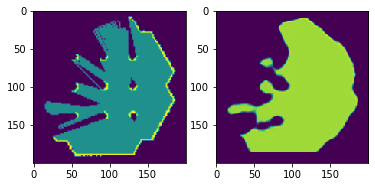

Epoch [15/30], Step [5/75], Loss: 0.041826
Epoch [15/30], Step [10/75], Loss: 0.042805
Epoch [15/30], Step [15/75], Loss: 0.040856
Epoch [15/30], Step [20/75], Loss: 0.042961
Epoch [15/30], Step [25/75], Loss: 0.042366
Epoch [15/30], Step [30/75], Loss: 0.042275
Epoch [15/30], Step [35/75], Loss: 0.040940
Epoch [15/30], Step [40/75], Loss: 0.042168
Epoch [15/30], Step [45/75], Loss: 0.041389
Epoch [15/30], Step [50/75], Loss: 0.040142
Epoch [15/30], Step [55/75], Loss: 0.041134
Epoch [15/30], Step [60/75], Loss: 0.040647
Epoch [15/30], Step [65/75], Loss: 0.040141
Epoch [15/30], Step [70/75], Loss: 0.040024
Epoch [15/30], Step [75/75], Loss: 0.040525
Epoch [15/30], Average Train Loss: 0.041497, Average Test Loss: 0.041584


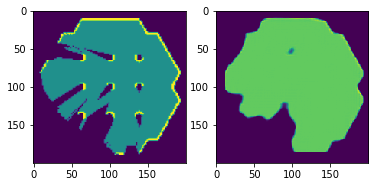

Epoch [16/30], Step [5/75], Loss: 0.042028
Epoch [16/30], Step [10/75], Loss: 0.042508
Epoch [16/30], Step [15/75], Loss: 0.040925
Epoch [16/30], Step [20/75], Loss: 0.040759
Epoch [16/30], Step [25/75], Loss: 0.041671
Epoch [16/30], Step [30/75], Loss: 0.041114
Epoch [16/30], Step [35/75], Loss: 0.040604
Epoch [16/30], Step [40/75], Loss: 0.040322
Epoch [16/30], Step [45/75], Loss: 0.040748
Epoch [16/30], Step [50/75], Loss: 0.039233
Epoch [16/30], Step [55/75], Loss: 0.039093
Epoch [16/30], Step [60/75], Loss: 0.041605
Epoch [16/30], Step [65/75], Loss: 0.040847
Epoch [16/30], Step [70/75], Loss: 0.040447
Epoch [16/30], Step [75/75], Loss: 0.036909
Epoch [16/30], Average Train Loss: 0.040683, Average Test Loss: 0.040227


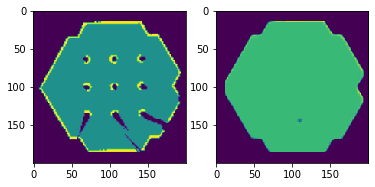

Epoch [17/30], Step [5/75], Loss: 0.040119
Epoch [17/30], Step [10/75], Loss: 0.039728
Epoch [17/30], Step [15/75], Loss: 0.039493
Epoch [17/30], Step [20/75], Loss: 0.039268
Epoch [17/30], Step [25/75], Loss: 0.042380
Epoch [17/30], Step [30/75], Loss: 0.038799
Epoch [17/30], Step [35/75], Loss: 0.039784
Epoch [17/30], Step [40/75], Loss: 0.039928
Epoch [17/30], Step [45/75], Loss: 0.039153
Epoch [17/30], Step [50/75], Loss: 0.039249
Epoch [17/30], Step [55/75], Loss: 0.038123
Epoch [17/30], Step [60/75], Loss: 0.038761
Epoch [17/30], Step [65/75], Loss: 0.038968
Epoch [17/30], Step [70/75], Loss: 0.039269
Epoch [17/30], Step [75/75], Loss: 0.041587
Epoch [17/30], Average Train Loss: 0.039484, Average Test Loss: 0.039799


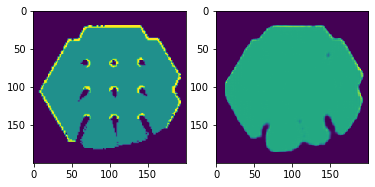

Epoch [18/30], Step [5/75], Loss: 0.039729
Epoch [18/30], Step [10/75], Loss: 0.037494
Epoch [18/30], Step [15/75], Loss: 0.040000
Epoch [18/30], Step [20/75], Loss: 0.038734
Epoch [18/30], Step [25/75], Loss: 0.036778
Epoch [18/30], Step [30/75], Loss: 0.037912
Epoch [18/30], Step [35/75], Loss: 0.038646
Epoch [18/30], Step [40/75], Loss: 0.038259
Epoch [18/30], Step [45/75], Loss: 0.038146
Epoch [18/30], Step [50/75], Loss: 0.037214
Epoch [18/30], Step [55/75], Loss: 0.038470
Epoch [18/30], Step [60/75], Loss: 0.036515
Epoch [18/30], Step [65/75], Loss: 0.037865
Epoch [18/30], Step [70/75], Loss: 0.037499
Epoch [18/30], Step [75/75], Loss: 0.037314
Epoch [18/30], Average Train Loss: 0.038153, Average Test Loss: 0.041875


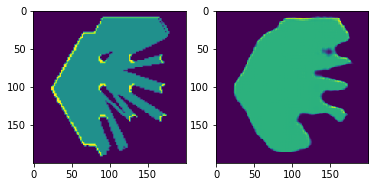

Epoch [19/30], Step [5/75], Loss: 0.039198
Epoch [19/30], Step [10/75], Loss: 0.039345
Epoch [19/30], Step [15/75], Loss: 0.038694
Epoch [19/30], Step [20/75], Loss: 0.037762
Epoch [19/30], Step [25/75], Loss: 0.036569
Epoch [19/30], Step [30/75], Loss: 0.036981
Epoch [19/30], Step [35/75], Loss: 0.037351
Epoch [19/30], Step [40/75], Loss: 0.036638
Epoch [19/30], Step [45/75], Loss: 0.035909
Epoch [19/30], Step [50/75], Loss: 0.036588
Epoch [19/30], Step [55/75], Loss: 0.036628
Epoch [19/30], Step [60/75], Loss: 0.036577
Epoch [19/30], Step [65/75], Loss: 0.037934
Epoch [19/30], Step [70/75], Loss: 0.037384
Epoch [19/30], Step [75/75], Loss: 0.032769
Epoch [19/30], Average Train Loss: 0.037557, Average Test Loss: 0.037731


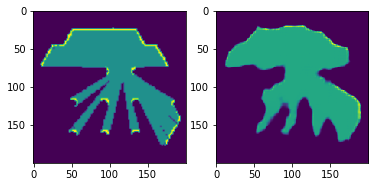

Epoch [20/30], Step [5/75], Loss: 0.035769
Epoch [20/30], Step [10/75], Loss: 0.037603
Epoch [20/30], Step [15/75], Loss: 0.039232
Epoch [20/30], Step [20/75], Loss: 0.038641
Epoch [20/30], Step [25/75], Loss: 0.037352
Epoch [20/30], Step [30/75], Loss: 0.036389
Epoch [20/30], Step [35/75], Loss: 0.036011
Epoch [20/30], Step [40/75], Loss: 0.036009
Epoch [20/30], Step [45/75], Loss: 0.034769
Epoch [20/30], Step [50/75], Loss: 0.034455
Epoch [20/30], Step [55/75], Loss: 0.035548
Epoch [20/30], Step [60/75], Loss: 0.035138
Epoch [20/30], Step [65/75], Loss: 0.034647
Epoch [20/30], Step [70/75], Loss: 0.034314
Epoch [20/30], Step [75/75], Loss: 0.039018
Epoch [20/30], Average Train Loss: 0.036120, Average Test Loss: 0.035898


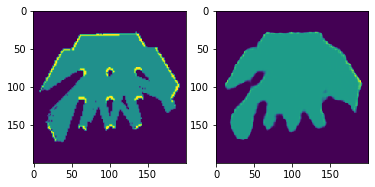

Epoch [21/30], Step [5/75], Loss: 0.035927
Epoch [21/30], Step [10/75], Loss: 0.036281
Epoch [21/30], Step [15/75], Loss: 0.035504
Epoch [21/30], Step [20/75], Loss: 0.034467
Epoch [21/30], Step [25/75], Loss: 0.034988
Epoch [21/30], Step [30/75], Loss: 0.035276
Epoch [21/30], Step [35/75], Loss: 0.035110
Epoch [21/30], Step [40/75], Loss: 0.034906
Epoch [21/30], Step [45/75], Loss: 0.034525
Epoch [21/30], Step [50/75], Loss: 0.034161
Epoch [21/30], Step [55/75], Loss: 0.034384
Epoch [21/30], Step [60/75], Loss: 0.034913
Epoch [21/30], Step [65/75], Loss: 0.037380
Epoch [21/30], Step [70/75], Loss: 0.035846
Epoch [21/30], Step [75/75], Loss: 0.037553
Epoch [21/30], Average Train Loss: 0.035053, Average Test Loss: 0.034570


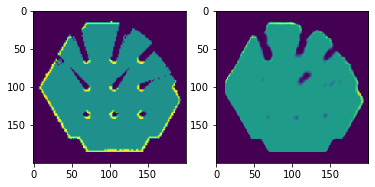

Epoch [22/30], Step [5/75], Loss: 0.034942
Epoch [22/30], Step [10/75], Loss: 0.035407
Epoch [22/30], Step [15/75], Loss: 0.034397
Epoch [22/30], Step [20/75], Loss: 0.033796
Epoch [22/30], Step [25/75], Loss: 0.033516
Epoch [22/30], Step [30/75], Loss: 0.034037
Epoch [22/30], Step [35/75], Loss: 0.035253
Epoch [22/30], Step [40/75], Loss: 0.034842
Epoch [22/30], Step [45/75], Loss: 0.034029
Epoch [22/30], Step [50/75], Loss: 0.033029
Epoch [22/30], Step [55/75], Loss: 0.031678
Epoch [22/30], Step [60/75], Loss: 0.033475
Epoch [22/30], Step [65/75], Loss: 0.032263
Epoch [22/30], Step [70/75], Loss: 0.032699
Epoch [22/30], Step [75/75], Loss: 0.031892
Epoch [22/30], Average Train Loss: 0.033767, Average Test Loss: 0.033319


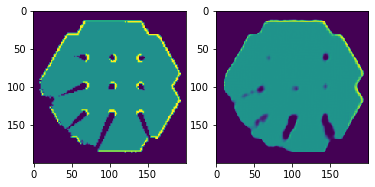

Epoch [23/30], Step [5/75], Loss: 0.033441
Epoch [23/30], Step [10/75], Loss: 0.033915
Epoch [23/30], Step [15/75], Loss: 0.032621
Epoch [23/30], Step [20/75], Loss: 0.034203
Epoch [23/30], Step [25/75], Loss: 0.032376
Epoch [23/30], Step [30/75], Loss: 0.031391
Epoch [23/30], Step [35/75], Loss: 0.031899
Epoch [23/30], Step [40/75], Loss: 0.033491
Epoch [23/30], Step [45/75], Loss: 0.033070
Epoch [23/30], Step [50/75], Loss: 0.034252
Epoch [23/30], Step [55/75], Loss: 0.032974
Epoch [23/30], Step [60/75], Loss: 0.033654
Epoch [23/30], Step [65/75], Loss: 0.033483
Epoch [23/30], Step [70/75], Loss: 0.033838
Epoch [23/30], Step [75/75], Loss: 0.031531
Epoch [23/30], Average Train Loss: 0.033135, Average Test Loss: 0.032618


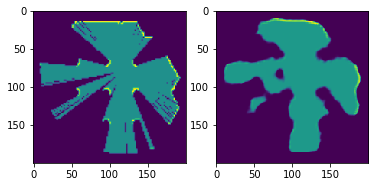

Epoch [24/30], Step [5/75], Loss: 0.032593
Epoch [24/30], Step [10/75], Loss: 0.033366
Epoch [24/30], Step [15/75], Loss: 0.031020
Epoch [24/30], Step [20/75], Loss: 0.030635
Epoch [24/30], Step [25/75], Loss: 0.031771
Epoch [24/30], Step [30/75], Loss: 0.031604
Epoch [24/30], Step [35/75], Loss: 0.032904
Epoch [24/30], Step [40/75], Loss: 0.031686
Epoch [24/30], Step [45/75], Loss: 0.031804
Epoch [24/30], Step [50/75], Loss: 0.031163
Epoch [24/30], Step [55/75], Loss: 0.031325
Epoch [24/30], Step [60/75], Loss: 0.030627
Epoch [24/30], Step [65/75], Loss: 0.032570
Epoch [24/30], Step [70/75], Loss: 0.032037
Epoch [24/30], Step [75/75], Loss: 0.030908
Epoch [24/30], Average Train Loss: 0.031679, Average Test Loss: 0.031248


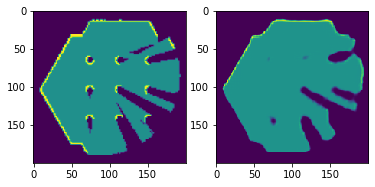

Epoch [25/30], Step [5/75], Loss: 0.030696
Epoch [25/30], Step [10/75], Loss: 0.031116
Epoch [25/30], Step [15/75], Loss: 0.031629
Epoch [25/30], Step [20/75], Loss: 0.030644
Epoch [25/30], Step [25/75], Loss: 0.031829
Epoch [25/30], Step [30/75], Loss: 0.030236
Epoch [25/30], Step [35/75], Loss: 0.031504
Epoch [25/30], Step [40/75], Loss: 0.030921
Epoch [25/30], Step [45/75], Loss: 0.029472
Epoch [25/30], Step [50/75], Loss: 0.029411
Epoch [25/30], Step [55/75], Loss: 0.030017
Epoch [25/30], Step [60/75], Loss: 0.029912
Epoch [25/30], Step [65/75], Loss: 0.030620
Epoch [25/30], Step [70/75], Loss: 0.031494
Epoch [25/30], Step [75/75], Loss: 0.025866
Epoch [25/30], Average Train Loss: 0.030696, Average Test Loss: 0.030708


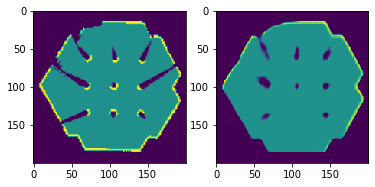

Epoch [26/30], Step [5/75], Loss: 0.030867
Epoch [26/30], Step [10/75], Loss: 0.030430
Epoch [26/30], Step [15/75], Loss: 0.030219
Epoch [26/30], Step [20/75], Loss: 0.029822
Epoch [26/30], Step [25/75], Loss: 0.030684
Epoch [26/30], Step [30/75], Loss: 0.029903
Epoch [26/30], Step [35/75], Loss: 0.028897
Epoch [26/30], Step [40/75], Loss: 0.031834
Epoch [26/30], Step [45/75], Loss: 0.030430
Epoch [26/30], Step [50/75], Loss: 0.028971
Epoch [26/30], Step [55/75], Loss: 0.030448
Epoch [26/30], Step [60/75], Loss: 0.028652
Epoch [26/30], Step [65/75], Loss: 0.028792
Epoch [26/30], Step [70/75], Loss: 0.028884
Epoch [26/30], Step [75/75], Loss: 0.026365
Epoch [26/30], Average Train Loss: 0.029827, Average Test Loss: 0.031692


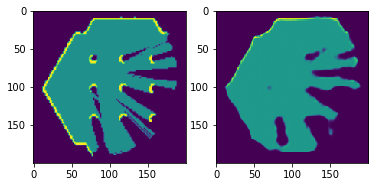

Epoch [27/30], Step [5/75], Loss: 0.032559
Epoch [27/30], Step [10/75], Loss: 0.029185
Epoch [27/30], Step [15/75], Loss: 0.029177
Epoch [27/30], Step [20/75], Loss: 0.031544
Epoch [27/30], Step [25/75], Loss: 0.031609
Epoch [27/30], Step [30/75], Loss: 0.028977
Epoch [27/30], Step [35/75], Loss: 0.029466
Epoch [27/30], Step [40/75], Loss: 0.031516
Epoch [27/30], Step [45/75], Loss: 0.029098
Epoch [27/30], Step [50/75], Loss: 0.029907
Epoch [27/30], Step [55/75], Loss: 0.030443
Epoch [27/30], Step [60/75], Loss: 0.028675
Epoch [27/30], Step [65/75], Loss: 0.029818
Epoch [27/30], Step [70/75], Loss: 0.029566
Epoch [27/30], Step [75/75], Loss: 0.029328
Epoch [27/30], Average Train Loss: 0.029780, Average Test Loss: 0.030037


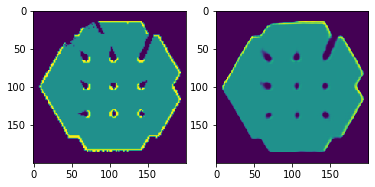

Epoch [28/30], Step [5/75], Loss: 0.029366
Epoch [28/30], Step [10/75], Loss: 0.028299
Epoch [28/30], Step [15/75], Loss: 0.029186
Epoch [28/30], Step [20/75], Loss: 0.027792
Epoch [28/30], Step [25/75], Loss: 0.027947
Epoch [28/30], Step [30/75], Loss: 0.028902
Epoch [28/30], Step [35/75], Loss: 0.028548
Epoch [28/30], Step [40/75], Loss: 0.029002
Epoch [28/30], Step [45/75], Loss: 0.028097
Epoch [28/30], Step [50/75], Loss: 0.028055
Epoch [28/30], Step [55/75], Loss: 0.027239
Epoch [28/30], Step [60/75], Loss: 0.027960
Epoch [28/30], Step [65/75], Loss: 0.027709
Epoch [28/30], Step [70/75], Loss: 0.027602
Epoch [28/30], Step [75/75], Loss: 0.026781
Epoch [28/30], Average Train Loss: 0.028274, Average Test Loss: 0.028244


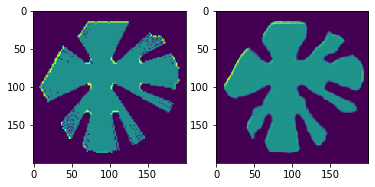

Epoch [29/30], Step [5/75], Loss: 0.027312
Epoch [29/30], Step [10/75], Loss: 0.027096
Epoch [29/30], Step [15/75], Loss: 0.028841
Epoch [29/30], Step [20/75], Loss: 0.027479
Epoch [29/30], Step [25/75], Loss: 0.028863
Epoch [29/30], Step [30/75], Loss: 0.027277
Epoch [29/30], Step [35/75], Loss: 0.026548
Epoch [29/30], Step [40/75], Loss: 0.028630
Epoch [29/30], Step [45/75], Loss: 0.028132
Epoch [29/30], Step [50/75], Loss: 0.026975
Epoch [29/30], Step [55/75], Loss: 0.027371
Epoch [29/30], Step [60/75], Loss: 0.028631
Epoch [29/30], Step [65/75], Loss: 0.026645
Epoch [29/30], Step [70/75], Loss: 0.027381
Epoch [29/30], Step [75/75], Loss: 0.026188
Epoch [29/30], Average Train Loss: 0.027756, Average Test Loss: 0.028586


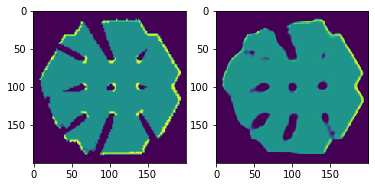

Epoch [30/30], Step [5/75], Loss: 0.026178
Epoch [30/30], Step [10/75], Loss: 0.027824
Epoch [30/30], Step [15/75], Loss: 0.026096
Epoch [30/30], Step [20/75], Loss: 0.026186
Epoch [30/30], Step [25/75], Loss: 0.029284
Epoch [30/30], Step [30/75], Loss: 0.026133
Epoch [30/30], Step [35/75], Loss: 0.028039
Epoch [30/30], Step [40/75], Loss: 0.026372
Epoch [30/30], Step [45/75], Loss: 0.028276
Epoch [30/30], Step [50/75], Loss: 0.026769
Epoch [30/30], Step [55/75], Loss: 0.027437
Epoch [30/30], Step [60/75], Loss: 0.027072
Epoch [30/30], Step [65/75], Loss: 0.027066
Epoch [30/30], Step [70/75], Loss: 0.027651
Epoch [30/30], Step [75/75], Loss: 0.028439
Epoch [30/30], Average Train Loss: 0.027411, Average Test Loss: 0.028917


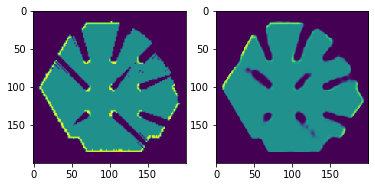

In [29]:
num_epochs = 30

for epoch in range(num_epochs):
    train_total_loss = 0.
    test_total_loss = 0.
    for i, [img] in enumerate(train_data_loader):
        outputs = autoencoder(img)
        loss = cirterion(outputs, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        if (i + 1) % 5 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_data_loader)}], Loss: {loss.item():.6f}")
    with torch.no_grad():
        for [img] in test_data_loader:
          outputs = autoencoder(img)
          loss = cirterion(outputs, img)
          test_total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}]"
            f", Average Train Loss: {train_total_loss / len(train_data_loader):.6f}"
            f", Average Test Loss: {test_total_loss / len(test_data_loader):.6f}")
    plot_result()

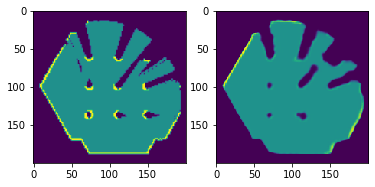

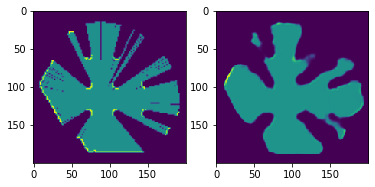

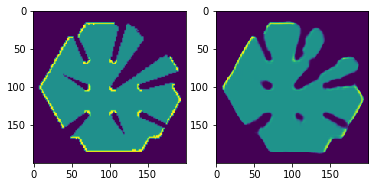

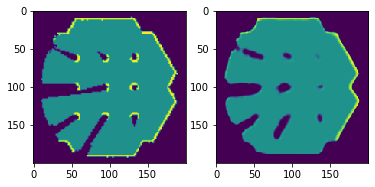

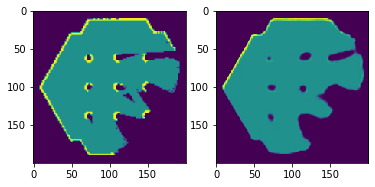

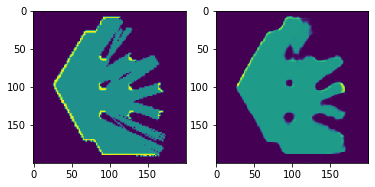

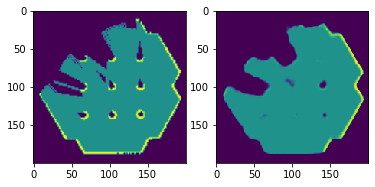

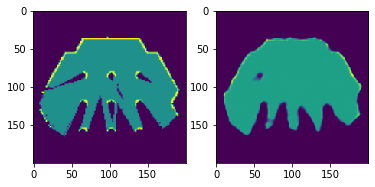

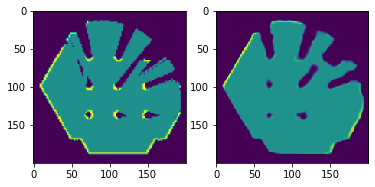

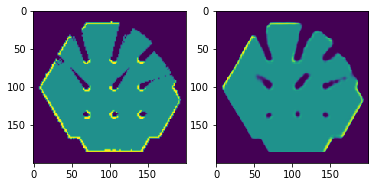

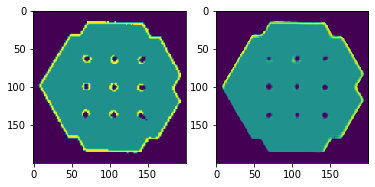

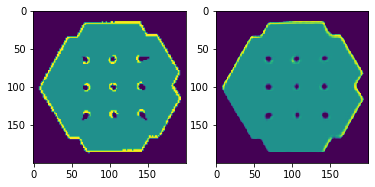

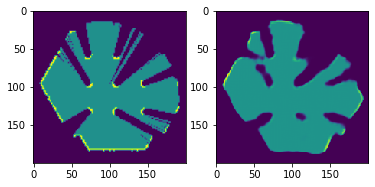

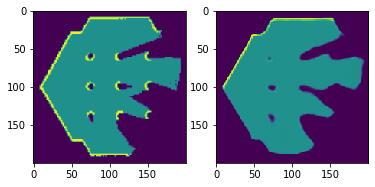

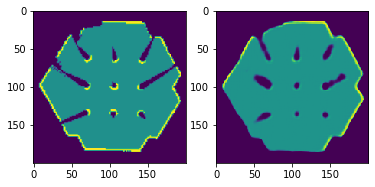

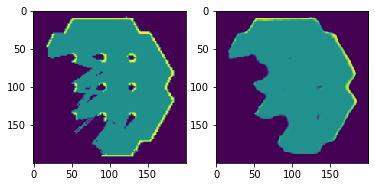

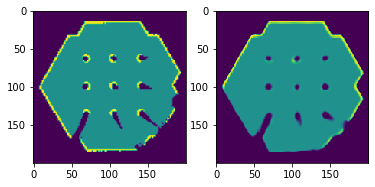

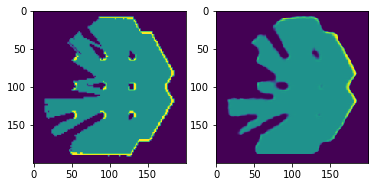

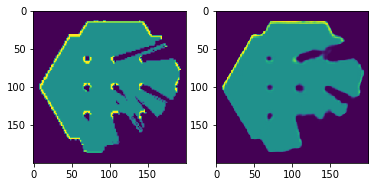

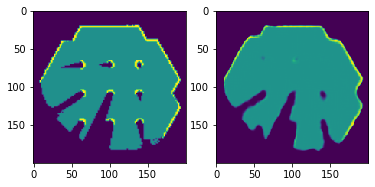

In [30]:
for _ in range(20):
  plot_result()

In [31]:
# TODO move const
weight_dir = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/weights/"

torch.save(autoencoder.state_dict(), weight_dir + "map_autoencoder_weight " + str(datetime.datetime.now())[:19])

In [37]:
weight_path = weight_dir + sorted([w for w in os.listdir(weight_dir) if "map_autoencoder" in w])[-1]

In [38]:
model = Autoencoder200()
model.load_state_dict(torch.load(weight_path))
model = model.to(device)

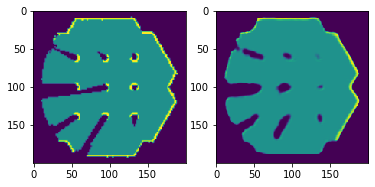

In [40]:
index = np.random.randint(len(test_data))

plt.subplot(1, 2, 1)
plt.imshow(test_data[index].cpu().squeeze())

with torch.no_grad():
    result = model(test_data[index])
plt.subplot(1, 2, 2)
plt.imshow(result[0].cpu().squeeze())
plt.show()